In [2]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [4]:
import torch
from torch import nn

import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

import networkx as nx

### Downloading the datasets

In [5]:
tu_dataset = torch_geometric.datasets.TUDataset(root='../data/', name="MUTAG", use_node_attr=True)

**Dataset objective**: predict the class of the molecule, if have a negative effect on salmonela's bacteries. 1 if True and 0 if False.

### Data format

| Graphs count | Classes | Avg. Nodes. | Avg. Edges | Node labels | Edge labels | Node attr. | Edge attr. |
| :----------: | :-----: | :---------: | :--------: | :---------: | :---------: | :--------: | :--------: |
| 188          | 2       | 17.93       | 19.79      | +           | +           | -          | -          |

`Data(edge_attr=[7442, 4], edge_index=[2, 7442], x=[3371, 7], y=[188])`

All graphs is put together in the initial data form. For access each of them we just need to pass an index to `tu_dataset` call. Like:

In [6]:
tu_dataset[0]

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

Each of the molecules have a number of nodes and edges.

Whats this object told to us?

`Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])`

In [5]:
'Average label: %4.2f' % (tu_dataset.data.y.float().mean().item())

'Average label: 0.66'

Significa que se o nosso modelo chutar somente a classe 1, vamos obter uma precisão aproximada de 66% nesse dataset. Também indica que temos as classes próximas de estarem balanceadas, próximo do 0.50 ou 50%.

In [62]:
tu_dataset[0]

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])

Informações dos Dados:
- Instância do objeto `torch_geometric.data.Data`
- Atributos:
    - **edge_attr**: Informa o tipo de ligação entre os átomos (tipo de aresta): 
        - `0`: aromática
        - `1`: ligação única
        - `2`: ligação dupla
        - `3`: ligação tripla
    - **edge_index**: Lista com duas sublistas indicando as ligações entre os átomos:
         - Ex.: `lista[0][0]` indica o átomo de ínicio na ligação 0 enquanto `lista[0][1]` indica o átomo final da ligação 0.
    - **x**: Lista dos átomos indicando seu tipo. Em ordem de formação para a molécula.
        - `0`: Carbono (C)
        - `1`: Nitrogênio (N)
        - `2`: Oxigênio (O)
        - `3`: Flúor (F)
        - `4`: Iodo (I)
        - `5`: Cloro (Cl)
        - `6`: Bromo (Br)
    - **y**: Variável alvo para predição, indica se uma determinada molécula tem efeito negativo em uma bactéria da salmonela.

#### Contagem das classes

In [66]:
y = tu_dataset.data.y.numpy()
y

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0], dtype=int64)

<AxesSubplot:ylabel='count'>

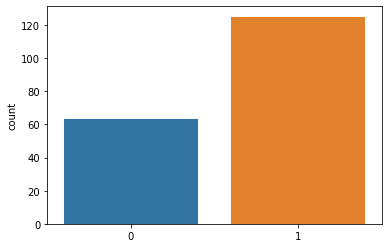

In [67]:
import seaborn as sns
sns.countplot(x = y)

### Visualizando as moléculas

In [74]:
atom_dict = {
    0: 'C',
    1: 'N',
    2: 'O',
    3: 'F',
    4: 'I',
    5: 'Cl',
    6: 'Br'
}

In [75]:
def mol_from_graph(atom_list, edge_list, edge_attr):
    mol = Chem.RWMol()
    node_to_idx = {}

    for i in range(len(atom_list)):
        a = Chem.Atom(atom_list[i])
        mol_idx = mol.AddAtom(a)
        node_to_idx[i] = mol_idx
    
    bond_list = list(zip(edge_list[0], edge_list[1]))
    bond_list = list({tuple(sorted(item)) for item in bond_list})

    for i, t in enumerate(bond_list):
        btype = edge_attr[i].index(1)
        
        if btype == 0:
            # aromatic
            bond_type = Chem.rdchem.BondType.AROMATIC
            mol.AddBond(t[0], t[1], bond_type)
        elif btype == 1:
            # single
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(t[0], t[1], bond_type)
        elif btype == 2:
            # double
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(t[0], t[1], bond_type)
        elif btype == 3:
            # triple
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(t[0], t[1], bond_type)
    
    mol = mol.GetMol()

    return mol


In [100]:
mols = []

for i in range(6):
    nodes = [atom_dict[atom.index(1)] for atom in tu_dataset[i].x.tolist()]
    edge_list = tu_dataset[i].edge_index.tolist()
    edge_attr = tu_dataset[i].edge_attr.tolist()
    mols.append(mol_from_graph(nodes, edge_list, edge_attr))

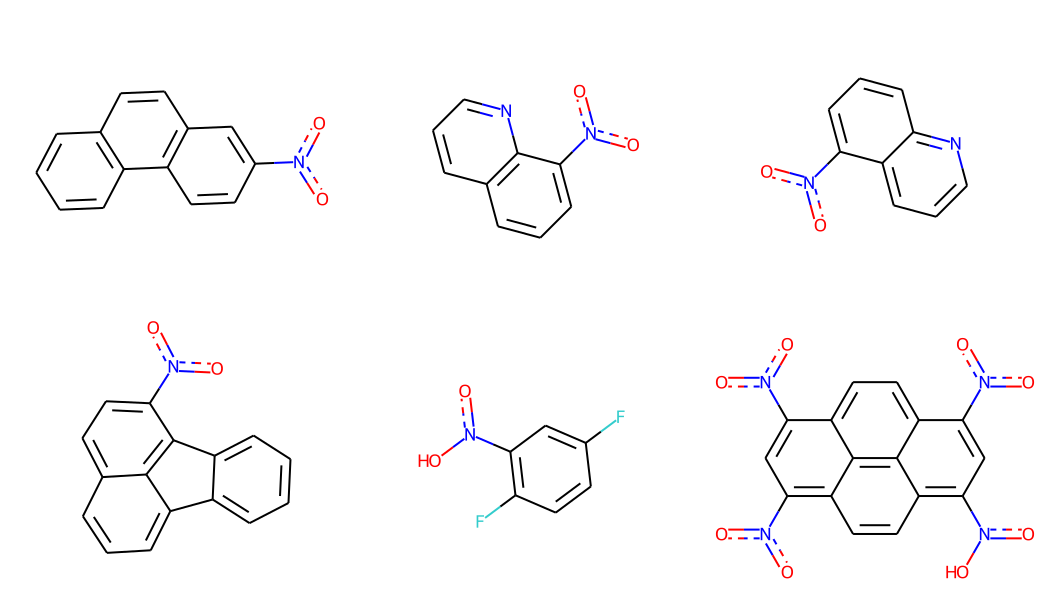

In [104]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(350,300))